The main aim of this notebook is to find the best model which can predict seperability of a given plot. And then calculate the AUC(Area Under Curve) scores for a bootstrapped sample for each seperation measure.

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score 
from sklearn.utils import resample
from sklearn.metrics import roc_curve,auc
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [18]:
# for plotting run this
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Read the CSV file and remove the last row from dataframe because the last row is the captured ACUBA scores for this dataset.

In [2]:
df=pd.read_csv("RESULTS_EUROVIS2015.csv");

AUC_scores=df.tail(1);

main_df=df[:-1];
number_of_rows=main_df.shape[0];
print("Total number of rows in original dataframe:"+str(len(df.index)));
print("Total number of rows in modified dataframe:"+str(len(main_df.index)));


Total number of rows in original dataframe:829
Total number of rows in modified dataframe:828


In [3]:
main_df.describe()

,indexFile,indexDR,classNum,scoreA,scoreM,scoreDes,DSC,CAL,HM,LDA,...,DC 20%,HDM 80,DC 2%,DUNN,DC 1%,DC 0.5%,CDM 1,DC 0.2%,DC 0.1%,AWTN
count,828.000000,828.000000,828.00000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,...,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000
mean,37.751208,2.450483,3.52657,2.979469,2.949275,0.507246,77.429402,80.298799,82.342098,0.594322,...,63.634851,98.403195,96.553164,0.027152,99.459394,99.935704,87.927730,99.996095,99.999158,270.766188
std,20.766822,1.115446,2.54403,1.631259,1.749717,0.500250,14.363301,118.300177,10.342507,1.481028,...,19.729777,3.748677,4.953790,0.059874,1.121827,0.185837,7.215781,0.019771,0.005084,78.268813
min,1.000000,1.000000,1.00000,0.000000,0.000000,0.000000,29.010239,0.007398,47.360794,0.000002,...,5.374185,53.901868,57.287289,0.000891,87.332331,97.799476,39.832298,99.711761,99.925354,38.993885
25%,16.000000,1.000000,2.00000,1.000000,1.000000,0.000000,66.650000,3.798646,75.515331,0.012565,...,52.270991,98.247322,95.165531,0.003489,99.374314,99.944297,84.619306,99.999112,100.000000,235.497898
50%,40.000000,3.000000,3.00000,3.000000,3.000000,1.000000,79.335260,24.730365,83.765962,0.091180,...,64.001399,100.000000,98.675758,0.007414,99.875350,99.992992,89.100684,100.000000,100.000000,286.045767
75%,55.000000,3.000000,5.00000,5.000000,5.000000,1.000000,89.450000,113.261177,90.789427,0.533361,...,76.557142,100.000000,99.852436,0.026669,100.000000,100.000000,92.874167,100.000000,100.000000,324.972774
max,70.000000,4.000000,13.00000,5.000000,5.000000,1.000000,100.000000,1038.602336,99.005716,25.837629,...,100.000000,100.000000,100.000000,0.707247,100.000000,100.000000,99.310559,100.000000,100.000000,457.396744


In [4]:
main_df.columns

Index(['fileName', 'indexFile', 'indexDR', 'classNum', 'scoreA', 'scoreM',
       'scoreDes', 'DSC', 'CAL', 'HM', 'LDA', 'WII', 'SIL', 'GAM', 'ABW', 'CS',
       'HDM 10', 'ABTN', 'HDM 5', 'CDM 4', 'CDM 3', 'DC 10%', 'CDM 5', 'CDM 2',
       'CDM 6', 'CDM 7', 'DC 5%', 'CDM 8', 'CDM 10', 'CDM 9', 'HDM 20',
       'HDM 40', 'DC 20%', 'HDM 80', 'DC 2%', 'DUNN', 'DC 1%', 'DC 0.5%',
       'CDM 1', 'DC 0.2%', 'DC 0.1%', 'AWTN'],
      dtype='object')

In [5]:
#rerranging the columms in the order given in the paper.
target_var='scoreDes'
file_descriptors=['fileName', 'indexFile', 'indexDR', 'classNum', 'scoreA', 'scoreM']+[target_var]


measure_cols=['ABTN','AWTN','ABW','WII','CAL','LDA','DUNN','GAM','SIL','HM','CS','DSC',
            'CDM 1','CDM 2','CDM 3','CDM 4','CDM 5', 'CDM 6', 'CDM 7', 'CDM 8', 'CDM 9', 'CDM 10',
           'DC 0.1%','DC 0.2%','DC 0.5%','DC 1%','DC 2%','DC 5%','DC 10%','DC 20%',
           'HDM 5','HDM 10','HDM 20','HDM 40','HDM 80']

new_cols=file_descriptors+measure_cols;

X_cols=measure_cols;
Y_cols=target_var;

X=main_df[X_cols];
Y=main_df[target_var];

bootstrap_sample_size=10000

In [6]:
mod_auc_scores=AUC_scores[X_cols];
actual_auc_scores=mod_auc_scores.values[0]
print(actual_auc_scores)

[0.75796  0.524822 0.77543  0.802286 0.812012 0.807314 0.632263 0.791216
 0.798531 0.811283 0.767223 0.825445 0.617904 0.73181  0.754523 0.755598
 0.736352 0.725799 0.719329 0.711536 0.710013 0.711477 0.563681 0.604139
 0.621176 0.625403 0.640985 0.71753  0.748782 0.655484 0.755787 0.763379
 0.707406 0.69294  0.655272]


In [7]:
#preprocessing 

scaler = StandardScaler().fit(X) 
X = scaler.transform(X) 
X=np.hstack((np.ones((X.shape[0], 1)), X))

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.05)

def get_train_test_accuracy(model):
    #model = LogisticRegression()
    model.fit(X_train, Y_train)
    predicted_classes = model.predict(X_train)
    train_accuracy = accuracy_score(Y_train,predicted_classes)
    predicted_classes = model.predict(X_test)
    test_accuracy = accuracy_score(Y_test,predicted_classes)
    return train_accuracy,test_accuracy

print(get_train_test_accuracy(LogisticRegression()))
print(get_train_test_accuracy(RandomForestClassifier()))


(0.8842239185750637, 0.8571428571428571)
(0.9949109414758269, 0.8571428571428571)


In [9]:
model_map={}
model_map[1]=LogisticRegression();
model_map[2]=RandomForestClassifier(n_estimators=4, max_depth=2, random_state=0)
model_map[3]=DecisionTreeClassifier(random_state=0)
model_map[4]=SVC(gamma='auto')
model_map[5]=KNeighborsClassifier(n_neighbors=3)
model_map[6]=AdaBoostClassifier(n_estimators=4,learning_rate=1,random_state=0)


def get_model_object(index):
    return model_map.get(index);

In [10]:
#this method calculates the AUC scores for each feature in the dataset.
def get_auc_scores(main_df,model_index):
    #input: dataset, model
    #output: List of AUC scores
    X_cols=measure_cols;
    Y_cols=target_var;

    X=main_df[X_cols];
    Y=main_df[target_var];
    
    scaler = StandardScaler().fit(X) 
    X = scaler.transform(X) 
    X=np.hstack((np.ones((X.shape[0], 1)), X))
    
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25)
    model=model_map.get(model_index);
    auc_vals=[]
    for i in range(1,X_train.shape[1]):
        model.fit(X_train[:,[i]],Y_train);
        preds=model.predict(X_test[:,[i]]);
        test_accuracy = accuracy_score(Y_test,preds);
        fpr, tpr, thresholds = roc_curve(Y_test, preds)
        auc_val=auc(fpr, tpr)
        auc_vals.append(auc_val)
    return auc_vals;


def get_bootstrapped_auc_scores(main_df,model):
    auc_scores=[]
    for i in range(bootstrap_sample_size):
        if i%5000==0:
            print("Iteration :"+str(i));
        sample_df=resample(main_df, replace=False, n_samples=main_df.shape[0], random_state=1)
        auc_scores.append(get_auc_scores(sample_df,model));
    return auc_scores;
    


In [11]:
model_index=1
auc_scores=get_bootstrapped_auc_scores(main_df,model_index);
calculated_AUC_scores=np.mean(auc_scores,axis=0);
output = pd.DataFrame({'Measure': X_cols, 'Expected': actual_auc_scores,'Calculated':calculated_AUC_scores})
output.sort_values("Calculated", inplace=True,ascending=False)
print("Calculated bootstrapped scores using Logistic Regression model")
print(output.head(10))

# import json
output.reset_index(drop=True).to_json('Logit_auc.json')

Iteration :0
Iteration :5000
Calculated bootstrapped scores using Logistic Regression model
   Measure  Expected  Calculated
3      WII  0.802286    0.785414
8      SIL  0.798531    0.773379
9       HM  0.811283    0.769410
7      GAM  0.791216    0.768687
2      ABW  0.775430    0.763472
11     DSC  0.825445    0.759815
5      LDA  0.807314    0.741550
4      CAL  0.812012    0.740945
10      CS  0.767223    0.720985
15   CDM 4  0.755598    0.719890


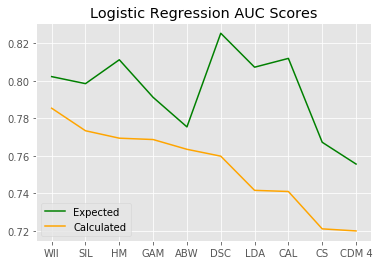

In [106]:
Expected = (0.802286, 0.798531, 0.811283, 0.791216, 0.775430, 0.825445, 0.807314, 0.812012, 0.767223, 0.755598)
Calculated = (0.785414, 0.773379, 0.769410, 0.768687, 0.763472, 0.759815, 0.741550, 0.740945, 0.720985, 0.719890)
Measure = ('WII', 'SIL', 'HM', 'GAM', 'ABW', 'DSC', 'LDA', 'CAL', 'CS', 'CDM 4')
plt.plot(Measure, Expected, color='g', label='Expected')
plt.plot(Measure, Calculated, color='orange', label='Calculated')
plt.title('Logistic Regression AUC Scores')
plt.legend(loc='best')
plt.show()

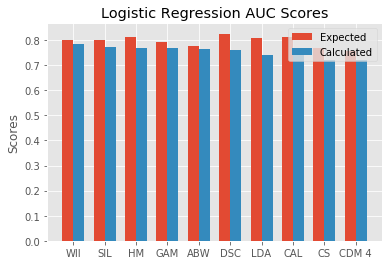

In [107]:
N = 10

ind = np.arange(N) 
width = 0.35       
plt.bar(ind, Expected, width, label='Expected')
plt.bar(ind + width, Calculated, width, label='Calculated')

plt.ylabel('Scores')
plt.title('Logistic Regression AUC Scores')

plt.xticks(ind + width / 2, Measure)
plt.legend(loc='best')
plt.show()

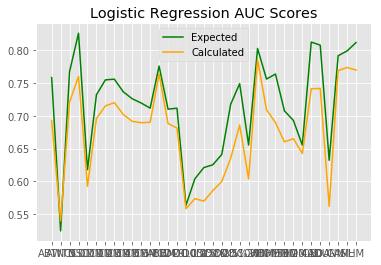

In [104]:
Expected = (0.802286, 0.798531, 0.811283, 0.791216, 0.775430, 0.825445, 0.807314, 0.812012, 0.767223, 0.755598)
Calculated = (0.785414, 0.773379, 0.769410, 0.768687, 0.763472, 0.759815, 0.741550, 0.740945, 0.720985, 0.719890)
year = df['Measure'].values
plt.plot(year, df['Expected'].values, color='g', label='Expected')
plt.plot(year, df['Calculated'].values, color='orange', label='Calculated')
plt.title('Logistic Regression AUC Scores')
plt.legend(loc='best')
plt.show()

In [12]:
model_index=2
auc_scores=get_bootstrapped_auc_scores(main_df,model_index);
calculated_AUC_scores=np.mean(auc_scores,axis=0);
output = pd.DataFrame({'Measure': X_cols, 'Expected': actual_auc_scores,'Calculated':calculated_AUC_scores})
output.sort_values("Calculated", inplace=True,ascending=False)
print("Calculated bootstrapped scores using Random Forest Classifier model")
print(output.head(10))

# import json
output.reset_index(drop=True).to_json('RF_auc.json')

Iteration :0
Iteration :5000
Calculated bootstrapped scores using Random Forest Classifier model
   Measure  Expected  Calculated
11     DSC  0.825445    0.795168
3      WII  0.802286    0.787267
8      SIL  0.798531    0.781373
9       HM  0.811283    0.778127
7      GAM  0.791216    0.771842
2      ABW  0.775430    0.764911
4      CAL  0.812012    0.734378
5      LDA  0.807314    0.733711
16   CDM 5  0.736352    0.727933
14   CDM 3  0.754523    0.724728


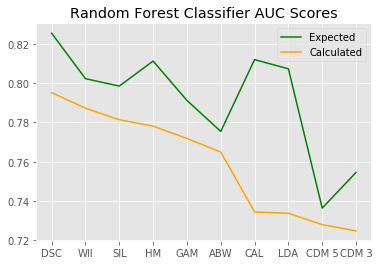

In [94]:
Expected = (0.825445, 0.802286, 0.798531, 0.811283, 0.791216, 0.775430, 0.812012, 0.807314, 0.736352, 0.754523)
Calculated = (0.795168, 0.787267, 0.781373, 0.778127, 0.771842, 0.764911, 0.734378, 0.733711, 0.727933, 0.724728)
year = ('DSC', 'WII', 'SIL', 'HM', 'GAM', 'ABW', 'CAL', 'LDA', 'CDM 5', 'CDM 3')
plt.plot(year, Expected, color='g', label='Expected')
plt.plot(year, Calculated, color='orange', label='Calculated')
plt.title('Random Forest Classifier AUC Scores')
plt.legend(loc='best')
plt.show()

In [13]:
#decision tree classifier
model_index=3
auc_scores=get_bootstrapped_auc_scores(main_df,model_index);
calculated_AUC_scores=np.mean(auc_scores,axis=0);
output = pd.DataFrame({'Measure': X_cols, 'Expected': actual_auc_scores,'Calculated':calculated_AUC_scores})
output.sort_values("Calculated", inplace=True,ascending=False)
print("Calculated bootstrapped scores using Decision Tree classifier model")
print(output.head(10))

# import json
output.reset_index(drop=True).to_json('DTree_auc.json')

Iteration :0
Iteration :5000
Calculated bootstrapped scores using Decision Tree classifier model
   Measure  Expected  Calculated
11     DSC  0.825445    0.724681
8      SIL  0.798531    0.701431
7      GAM  0.791216    0.687322
3      WII  0.802286    0.680179
5      LDA  0.807314    0.669360
33  HDM 40  0.692940    0.664187
2      ABW  0.775430    0.660763
30   HDM 5  0.755787    0.659827
16   CDM 5  0.736352    0.659676
34  HDM 80  0.655272    0.656764


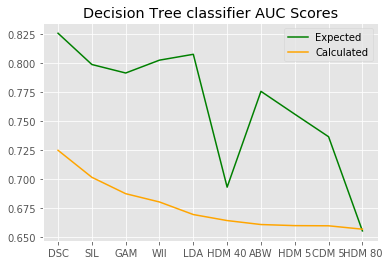

In [95]:
Expected = (0.825445, 0.798531, 0.791216, 0.802286, 0.807314, 0.692940, 0.775430, 0.755787, 0.736352, 0.655272)
Calculated = (0.724681, 0.701431, 0.687322, 0.680179, 0.669360, 0.664187, 0.660763, 0.659827, 0.659676, 0.656764)
year = ('DSC', 'SIL', 'GAM', 'WII', 'LDA', 'HDM 40', 'ABW', 'HDM 5', 'CDM 5', 'HDM 80')
plt.plot(year, Expected, color='g', label='Expected')
plt.plot(year, Calculated, color='orange', label='Calculated')
plt.title('Decision Tree classifier AUC Scores')
plt.legend(loc='best')
plt.show()

In [14]:
#support vector machine
model_index=4
auc_scores=get_bootstrapped_auc_scores(main_df,model_index);
calculated_AUC_scores=np.mean(auc_scores,axis=0);
output = pd.DataFrame({'Measure': X_cols, 'Expected': actual_auc_scores,'Calculated':calculated_AUC_scores})
output.sort_values("Calculated", inplace=True,ascending=False)
print("Calculated bootstrapped scores using SVM model")
print(output.head(10))

# import json
output.reset_index(drop=True).to_json('SVM_auc.json')

Iteration :0
Iteration :5000
Calculated bootstrapped scores using SVM model
   Measure  Expected  Calculated
11     DSC  0.825445    0.793487
3      WII  0.802286    0.790226
8      SIL  0.798531    0.785038
9       HM  0.811283    0.777890
7      GAM  0.791216    0.776251
2      ABW  0.775430    0.768785
5      LDA  0.807314    0.741168
4      CAL  0.812012    0.737553
16   CDM 5  0.736352    0.727215
15   CDM 4  0.755598    0.726831


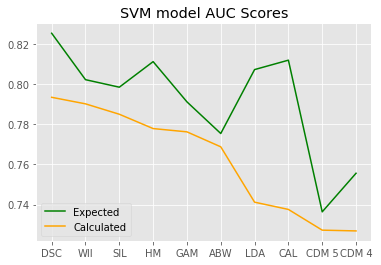

In [97]:
Expected = (0.825445, 0.802286, 0.798531, 0.811283, 0.791216, 0.775430, 0.807314, 0.812012, 0.736352, 0.755598)
Calculated = (0.793487, 0.790226, 0.785038, 0.777890, 0.776251, 0.768785, 0.741168, 0.737553, 0.727215, 0.726831)
year = ('DSC', 'WII', 'SIL', 'HM', 'GAM', 'ABW', 'LDA', 'CAL', 'CDM 5', 'CDM 4')
plt.plot(year, Expected, color='g', label='Expected')
plt.plot(year, Calculated, color='orange', label='Calculated')
plt.title('SVM model AUC Scores')
plt.legend(loc='best')
plt.show()

In [15]:
#knn model
model_index=5
auc_scores=get_bootstrapped_auc_scores(main_df,model_index);
calculated_AUC_scores=np.mean(auc_scores,axis=0);
output = pd.DataFrame({'Measure': X_cols, 'Expected': actual_auc_scores,'Calculated':calculated_AUC_scores})
output.sort_values("Calculated", inplace=True,ascending=False)
print("Calculated bootstrapped scores using K-Nearest Neighbours model")
print(output.head(10))

# import json
output.reset_index(drop=True).to_json('Knn_auc.json')

Iteration :0
Iteration :5000
Calculated bootstrapped scores using K-Nearest Neighbours model
   Measure  Expected  Calculated
11     DSC  0.825445    0.749448
3      WII  0.802286    0.732937
8      SIL  0.798531    0.729776
7      GAM  0.791216    0.707670
9       HM  0.811283    0.707278
2      ABW  0.775430    0.705431
5      LDA  0.807314    0.682120
19   CDM 8  0.711536    0.680529
4      CAL  0.812012    0.678065
20   CDM 9  0.710013    0.676876


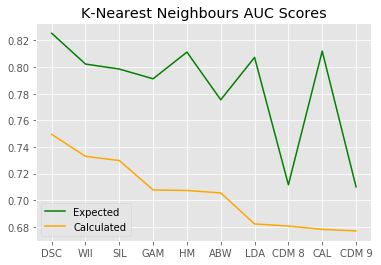

In [98]:
Expected = (0.825445, 0.802286, 0.798531, 0.791216, 0.811283, 0.775430, 0.807314, 0.711536, 0.812012, 0.710013)
Calculated = (0.749448, 0.732937, 0.729776, 0.707670, 0.707278, 0.705431, 0.682120, 0.680529, 0.678065, 0.676876)
year = ('DSC', 'WII', 'SIL', 'GAM', 'HM', 'ABW', 'LDA', 'CDM 8', 'CAL', 'CDM 9')
plt.plot(year, Expected, color='g', label='Expected')
plt.plot(year, Calculated, color='orange', label='Calculated')
plt.title('K-Nearest Neighbours AUC Scores')
plt.legend(loc='best')
plt.show()

In [16]:
model_index=6
auc_scores=get_bootstrapped_auc_scores(main_df,model_index);
calculated_AUC_scores=np.mean(auc_scores,axis=0);
output = pd.DataFrame({'Measure': X_cols, 'Expected': actual_auc_scores,'Calculated':calculated_AUC_scores})
output.sort_values("Calculated", inplace=True,ascending=False)
print("Calculated bootstrapped scores using Adaboost Classifier model")
print(output.head(10))

# import json
output.reset_index(drop=True).to_json('Adaboost_auc.json')

Iteration :0
Iteration :5000
Calculated bootstrapped scores using Adaboost Classifier model
   Measure  Expected  Calculated
11     DSC  0.825445    0.795208
3      WII  0.802286    0.785851
8      SIL  0.798531    0.782675
9       HM  0.811283    0.780319
7      GAM  0.791216    0.771615
2      ABW  0.775430    0.766233
4      CAL  0.812012    0.731957
14   CDM 3  0.754523    0.729617
5      LDA  0.807314    0.727001
16   CDM 5  0.736352    0.725873


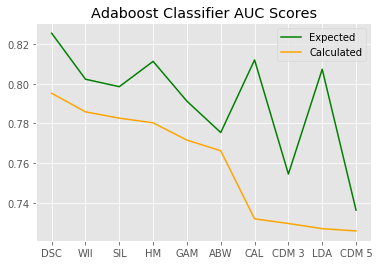

In [99]:
Expected = (0.825445, 0.802286, 0.798531, 0.811283, 0.791216, 0.775430, 0.812012, 0.754523, 0.807314, 0.736352)
Calculated = (0.795208, 0.785851, 0.782675, 0.780319, 0.771615, 0.766233, 0.731957, 0.729617, 0.727001, 0.725873)
year = ('DSC', 'WII', 'SIL', 'HM', 'GAM', 'ABW', 'CAL', 'CDM 3', 'LDA', 'CDM 5')
plt.plot(year, Expected, color='g', label='Expected')
plt.plot(year, Calculated, color='orange', label='Calculated')
plt.title('Adaboost Classifier AUC Scores')
plt.legend(loc='best')
plt.show()